# COAV_HW2-Image Classification with PyTorch



### 1. Load and Normalize CIFAR 10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

Before getting start, first we declare those hyperparameter that we will use in this homework.

In [3]:
EPOCH = 2
batch_size = 4
learning_rate = 0.001
momentum = 0.0

`If running on Windows and you get a BrokenPipeError, try setting the num_worker of torch.utils.data.DataLoader() to 0.`
 

In [4]:

transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), transforms.ToTensor(), transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.261))])



trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0) 

classes = ( 'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


`DataLoader` will pack the dataset depends on your batch_size. So if bath_size = 10, `DataLoader` will only have size with `datasets/batch_size`
<img width = '800' src = './resources/DataLoader_and_batch_size.png'>


### Visualize our dataset

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
ship  ship  horse car  


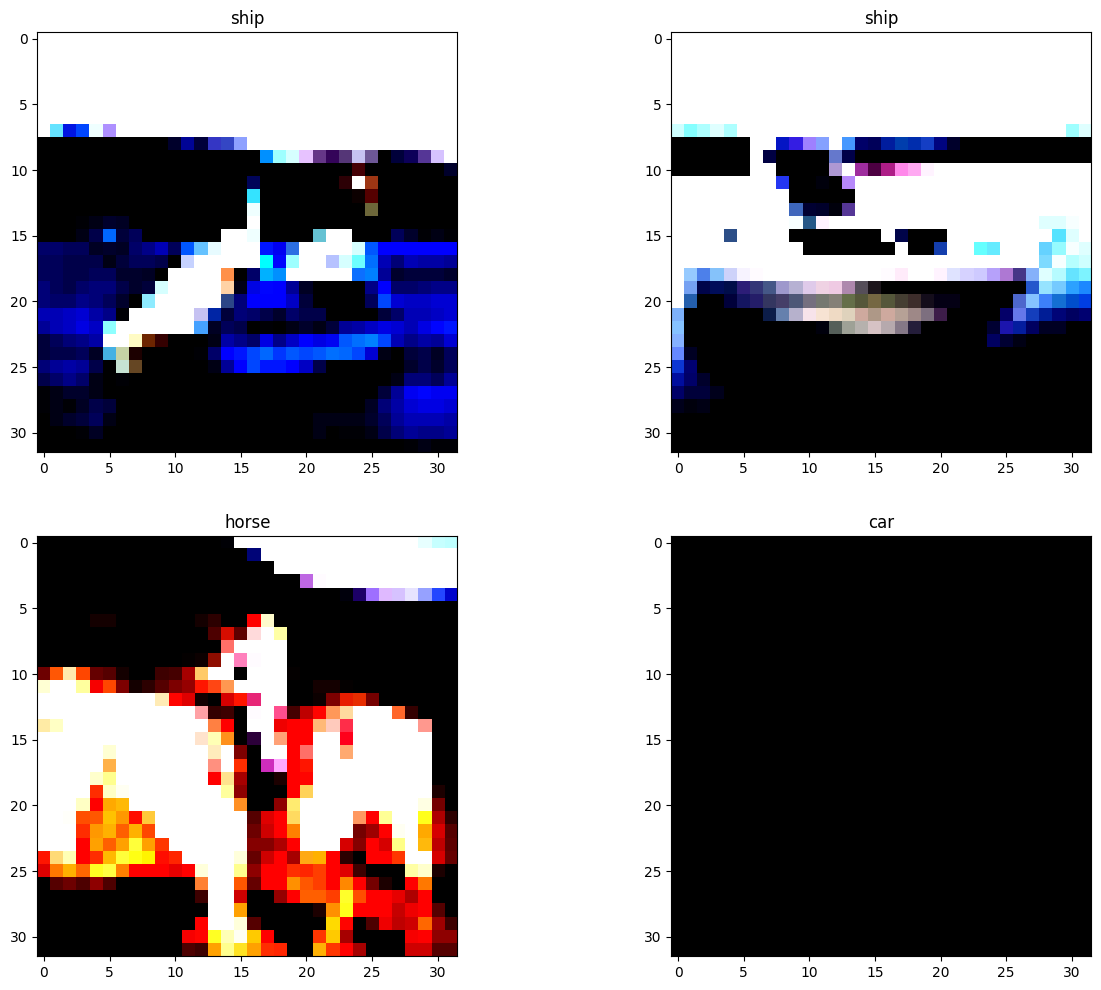

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, labels, classes):
    print(type(img))
    fig = plt.figure(figsize=(15,12), dpi=100)
    for i, _ in enumerate(img):
        img[i][0] = (img[i][0] * 0.247) + 0.491
        img[i][1] = (img[i][1] * 0.243) + 0.482
        img[i][2] = (img[i][2] * 0.261) + 0.447
    
    npimg = img.numpy()  # return PyTorch tensors as numpy ndarray
    for i, image in enumerate(npimg):
        fig.add_subplot(2,2, i + 1, title=classes[labels[i]])
        
        plt.imshow(np.transpose(image,(1,2,0)))
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()
    # print(img)



imshow(images, labels, classes)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d applies a 2D convolution 
        # syntax torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # nn.MaxPool2d applies a 2D maximum pooling
        # syntax  torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1,return_indices=False,ceil_mode=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # nn.Linear applies a normal linear transformation of y = xA + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # define forward propagation algorithm
    def forward(self, x):
        # if inplace is true, it will change the content of the given Tensor directly instead of make a copy of it 
        x = self.pool(F.relu(self.conv1(x), inplace=False))
        x = self.pool(F.relu(self.conv2(x), inplace=False))
        # torch.flatten(input, start_dim, end_dim=-1)
        # start_dim default is 0
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


### 3. Define a Loss function and optimizer

We will use `Cross-Entropy loss` amd `SGD with momentum` in this homework

In [45]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

### 4. Train the network

Now it's the time we start to train our network. We have to loop over our data iterator, and feed the inputs to the network and optimize.

In [46]:
from tqdm import tqdm 
# loop over the dataset multiple times
for epoch in range(EPOCH): 
    running_loss = 0.0
    # enumerate(iterable , start), default is 0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs; dat is a list of [inputs, labels]
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        # zero_grad() sets the gradients of all optimized torch.Tensors to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # optimizer.step() update parameters
        optimizer.step() 

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            # print("[{:d}, {:5d}] loss : {:.3f}".format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    print(i)
print("Finished Training")

  0%|          | 0/12500 [00:00<?, ?it/s]


NameError: name 'device' is not defined

In [ ]:
# Save the trained model:
PATH = './params/cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on test data

We have trained our model with our training dataset. But we need to check if the network has learnt anything at all. 

We will check this by compare the prediction made by our network with the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

First, let us display an image fro the test set.

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{:5s}'.format(classes[labels[j]]) for j in range(batch_size)))

In [ ]:
# Load back the parameters
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)
print(outputs)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:


In [ ]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("{:5s}".format(classes[predicted[j]]) for j in range(batch_size)))


Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

# torch.no_grad() is a context-manager that disabled gradient calculation
with torch.no_grad():
    for data in testloader:
        images, labels = data[0], data[1]
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the 10000 test images: {} %'. format(100 * correct // total))

- #### With Statement

In Python, with statement is used in exception handling to make the code cleaner and much more readable. It simplifies the management of common resources like file streams. Observe the following code example on how the use of with statement makes code cleaner. 

[reference](https://www.geeksforgeeks.org/with-statement-in-python/)

In [ ]:
# file handling
 
# 1) without using with statement
file = open('file_path', 'w')
file.write('hello world !')
file.close()
 
# 2) without using with statement
file = open('file_path', 'w')
try:
    file.write('hello world')
finally:
    file.close()
# using with statement
with open('file_path', 'w') as file:
    file.write('hello world !')

In [ ]:
# using with statement
with open('file_path', 'w') as file:
    file.write('hello world !')

Let see what are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predixtions for each class
correct_pred = {classname : 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# no gradients needed here
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
# dict.items() return both keys and values
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class: {:5s} is {:.1f}%".format(classname, accuracy))
    

### 6. Training on GPU

Let's first define our device as the first visible cuda device if we have CUDA available:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

These methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

In [ ]:
net.to(device)

Remember that you will have to send the inputs and all necessary variable that will interact with the network to CUDA:

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)

### 7. Plot our result

Plot the curve of testing accuracy, training accuracy and loss as epochs change.